In [67]:
# Importing packages
import matplotlib.pyplot as plt
import csv
import numpy as np
from google.colab.patches import cv2_imshow
from PIL import Image
import seaborn as sns
from skimage.morphology import flood_fill
import pandas as pd

# Instruction to run the code


### To run on given data files
*   Replace `.....pd.read_csv(_here_,....` with file_url1 or file_url2 or file_url3
*   perform `Run all` 

### To run on custom file 

*   Replace `file_urlx` with custom data file link
*   perform `Run all`


In [68]:
# Get input data from the files
x = [] # time axis 
y = [] # signal

file_url1 = 'https://raw.githubusercontent.com/ThusharaSampath/Radar_Cloud_Detection/main/raw_data1.csv'
file_url2 = 'https://raw.githubusercontent.com/ThusharaSampath/Radar_Cloud_Detection/main/raw_data2.csv'
file_url3 = 'https://raw.githubusercontent.com/ThusharaSampath/Radar_Cloud_Detection/main/raw_data3.csv'

#open file and map data into array y. 
f=pd.read_csv(file_url3,sep=';', header=None, squeeze=True)
t=0
for row in f:
    x.append(t)
    y.append((float(row)))
    t=t+1

# Define Constants

In [69]:
# Constants 
N = 30 # Number of range bins
fr = 1800 # Pulse repetition frequency
F = 1080000 # Original sampling frequency
K = 2.0 # Constant k in equation Vth = Vn_avg + k.sigma
SIGMA = 1 # Constant sigma in equation Vth = Vn_avg + k.sigma
RPM = 12 # RPM of the radar
THITA_H = 2 # Horizontal Beam Width
GUARD_BAND = 4
WINDOW_SIZE=10 # Actual window size is 21, here 10m = (actual; window size)/2. it for sake of convenience
k = 0.5 # Constant of non-coherent binary integration target selecting 
C=3*10**8 # speed of light



# Derive necessary values

In [70]:
# calculating necessary constants

# sampling time Ts = 1/(N.fr)
Ts = (1/(N*fr))
fs = int(1/Ts)

print(f"down sampling frequancy = {fs} Hz")
print(f"sampling factor = {int(F/fs)}")

# time taken to collect given data
T_sampled = len(y)/F

# angle rotated with in collecting data
Thita_rotated = (T_sampled * (RPM/60)*360) # in degree

#number of echoes per echos per sweep n=(thitaH * fr)/(6*N)
n=int((THITA_H*fr)/(6*RPM))
#number of echos expected for rotated angle
n=int((n/THITA_H)*Thita_rotated)

print(f"rotated angle = {Thita_rotated}")
print(f"number of echos expected = {n}")

obj_accepting_threshold = int(n*k)

print(f"target object accepting threshold   = {obj_accepting_threshold}")

down sampling frequancy = 54000 Hz
sampling factor = 20
rotated angle = 1.2000000000000002
number of echos expected = 30
target object accepting threshold   = 15


# Sampling

In [71]:
# Sampling
sampled_signal = []
positions = [] # respective sample postions of original signal 
length = len(y)
for row in range(0,length,int(F/fs)): # start sampling from 0 
    sampled_signal.append(y[row])
    positions.append(row)  

pulse_count = int(len(sampled_signal)/N) # possible pulse count calculating 
print(f"pulse count   = {pulse_count}")

pulse count   = 30


# Object Detection

## get_Vn_avg (n) : returns signle average value

### Input
*   n - position of original signal (an index)

### Output
*   moving avarage around given index for defined m=(window_size-1)/2 and guard band

Assumptions
*   not implementing compensation for case : n=0 is not an issue when considering 18000 data points



In [72]:
# Averaging function
SIGNAL=y # using original signal for thresholding (as per instructions)

def get_Vn_avg(n): 
  pass_video = SIGNAL[n-WINDOW_SIZE:n-GUARD_BAND]
  future_video = SIGNAL[n+GUARD_BAND+1:n+WINDOW_SIZE+1]
  avg = (sum(pass_video)+sum(future_video))/(2*(WINDOW_SIZE-GUARD_BAND))
  return avg

In [73]:
# Averaging
Vn_avgs = []
for i in positions: # slide the moving window on original data samples with stride of sampling factor (original_sampling_f / down_sampling_f)
  Vn_avgs.append(get_Vn_avg(i))

In [74]:
# Threshold calculating using equation Vth = Vn_avg + K*SIGMA
Vth = []
for i in Vn_avgs:
  Vth.append(i+K*SIGMA)

## Threshold sampled signal with Vth
### method
if ${i^{th} sample > i^{th} Vth }$ then thresholed value = 1, otherwise thresholed value 0.

In [75]:
# Thresholding sampled signal 
thresholded=[]
for i in range(len(positions)):
  if(Vth[i]<=sampled_signal[i]):
    thresholded.append(1)
  else:
    thresholded.append(0)


## Visualization

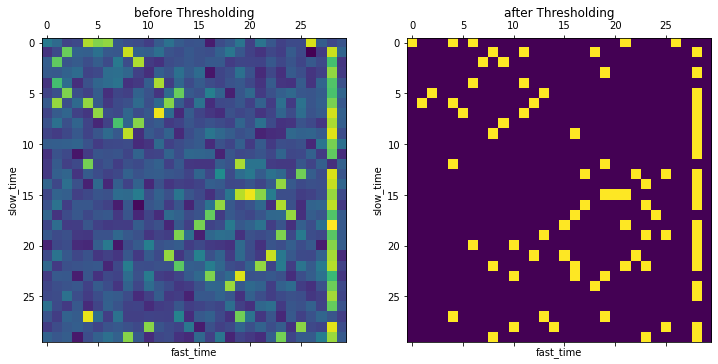

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))

# before Thresholding
mat = np.reshape(sampled_signal, (pulse_count, N))
ax1.set_title("before Thresholding")
ax1.set(xlabel='fast_time', ylabel='slow_time')
ax1.matshow(mat)


# After Thresholding 
mat = np.reshape(thresholded, (pulse_count, N))
ax2.set_title("after Thresholding")
ax2.set(xlabel='fast_time', ylabel='slow_time')
ax2.matshow(mat)


No handles with labels found to put in legend.


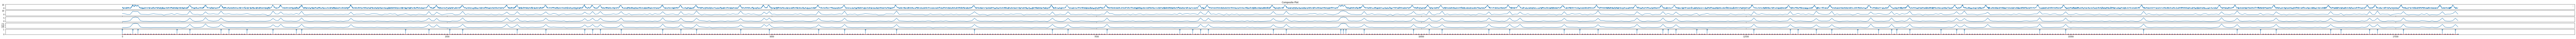

In [77]:
# with respect to time axis
plt.subplot(511)
plt.legend()
plt.title('Composite Plot')
plt.plot(x,y, label='Original')

plt.subplot(512)
plt.plot(positions,sampled_signal, label='Sampled')

plt.subplot(513)
plt.plot(positions,Vn_avgs, label='Vn_avg')

plt.subplot(514)
plt.plot(positions,Vth, label='Vth')

plt.subplot(515)
plt.stem(positions,thresholded, label='thresholded', use_line_collection=True)

# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (250,3)

plt.show()


## Post integrating

*   Thresholded matrix: `mat` contains 30*30 matrix.
*   To count possible object presences, add all rows together. since bins with objects contain 1's. row accumulated array : `integrated_arr` contain correct counts.




In [78]:
# Integrating
integrated_arr = np.sum(mat, axis=0)
integrated_arr

array([ 1,  1,  1,  0,  4,  1,  3,  1,  4,  2,  3,  3,  2,  3,  1,  2,  4,
        2,  2,  5,  1,  4,  2,  5,  1,  3,  1,  0, 22,  0])

## Post detection

*   itereate over `integrated_arr` and if the value is greater than *object_accepting_threshold = k×number_of_echos_expected*, fill that range bin row with 0.5 
*   collect possible object slots indices for future usagess

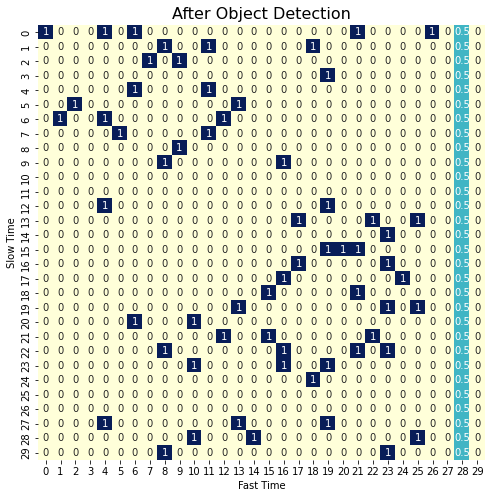

In [79]:
# post detection 
post_mat = mat.astype(float)
possible_object_slots=[]

for i in range(len(integrated_arr)):
  if (integrated_arr[i]>obj_accepting_threshold):
    post_mat[:, i]= 0.5
    possible_object_slots.append(i)

f, ax = plt.subplots(figsize=(8,8))
plt.title("After Object Detection",fontsize = 16)
ax = sns.heatmap(post_mat, square=False,annot=True,cbar=False,cmap="YlGnBu")
ax=ax.set(xlabel="Fast Time",ylabel="Slow Time")


## Calculating *Azimuth angle* and *range*

For each possible target bin calculate A𝑧𝑖𝑚𝑢𝑡ℎ A𝑛𝑔𝑙𝑒 using,
${ A𝑧𝑖𝑚𝑢𝑡ℎ A𝑛𝑔𝑙𝑒 =   𝑛 + (𝑚-𝑛)/2  × (𝑅𝑎𝑑𝑎𝑟  𝑅𝑜𝑡𝑎𝑡𝑖𝑜𝑛 𝑆𝑝𝑒𝑒𝑑(𝑑𝑒𝑔/𝑠𝑒𝑐) / 𝑃𝑢𝑙𝑠𝑒 𝑅𝑒𝑝𝑖𝑡𝑖𝑜𝑛 𝐹𝑟𝑒𝑞𝑢𝑒𝑛𝑐𝑦)}$

For get n,m range when bin has an object, in `find_n_m` function, iterate through the pulses of that bin and get first pulse and last pulse which has value 1. 

**NOTE : Angular Resolution of a radar = R×θH where θH = 2°. In this given data sets, radar is only rotated 1.2°. Almost all angles are below angular resolution. Hence, azimuth angle is not very useful here.**

${△R = (C×Ts)/2 = 3×10^8×(1/54000) = 2778m}$

So for ${n^{th}}$ range bin, the range is ${n×2778m}$.


In [80]:
# calculating 𝐴𝑧𝑖𝑚𝑢𝑡ℎ 𝑎𝑛𝑔𝑙𝑒
print(f"{len(possible_object_slots)} target/s were/was detected. \n")

def find_n_m(mat,possible_object_slots):
  result=[]
  for p in possible_object_slots:
    t_mat = list(mat[:,p])
    t_mat_r = t_mat[::-1]
    n = t_mat.index(1)
    m = t_mat_r.index(1)
    result.append([n+1,pulse_count-m]) #find first and last occurence of 1
  return result

result = find_n_m(mat,possible_object_slots)

d_R = (C*Ts)/2

for i in range(len(possible_object_slots)):
  n,m = result[i][0],result[i][1]
  𝐴_angle =(n + (m-n)/2)*((RPM*360/60)/fr)
  R=d_R * (possible_object_slots[i]+1)
  print(f"Target {i+1} : azimuth angle = {𝐴_angle}° | Range = {R/1000}km")


1 target/s were/was detected. 

Target 1 : azimuth angle = 0.64° | Range = 80.55555555555556km


# Cloud Detection

## Remove possible objects from  bins and make binary 30*30 matrix. 


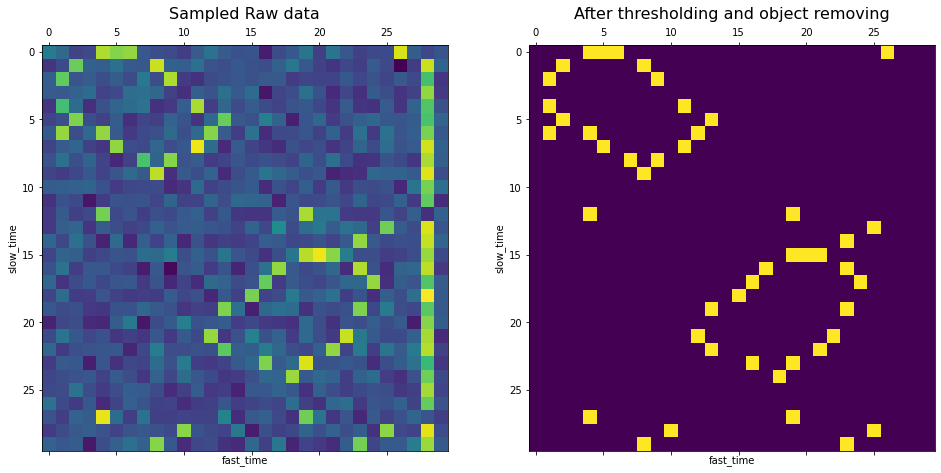

In [81]:
#apply thresholding step1

filtered0=[]
for i in range(len(sampled_signal)):
  if(Vth[i]<=sampled_signal[i]):
    filtered0.append(sampled_signal[i])
  else:
    filtered0.append(sampled_signal[i])

Gamma = 6 # a tunable parameter

# thresholding (step 2) and binary mapping
filtered1=[]
for i in range(len(filtered0)):
  if(Gamma<=sampled_signal[i]):
    filtered1.append(1)
  else:
    filtered1.append(0)

filtered2 = np.array(filtered1).reshape(pulse_count,N)

#remove possible object target bins' data
filtered2[:,possible_object_slots] = 0

f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))

# f, ax = plt.subplots(2,figsize=(8,8))
ax1.set_title('Sampled Raw data',fontsize = 16)
ax1.set(xlabel='fast_time', ylabel='slow_time')
ax1.matshow(np.array(sampled_signal).reshape(pulse_count,N))

# f, ax = plt.subplots(figsize=(8,8))
ax2.set_title('After thresholding and object removing',fontsize = 16)
ax2.set(xlabel='fast_time', ylabel='slow_time')
ax2.matshow(filtered2)

plt.show()

No handles with labels found to put in legend.


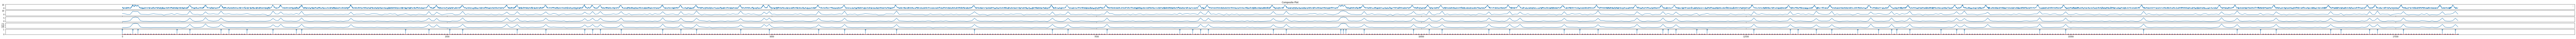

In [82]:
# with respect to time axis
plt.subplot(511)
plt.legend()
plt.title('Composite Plot')
plt.plot(x,y, label='Original')

plt.subplot(512)
plt.plot(positions,sampled_signal, label='Sampled')

plt.subplot(513)
plt.plot(positions,Vn_avgs, label='Vn_avg')

plt.subplot(514)
plt.plot(positions,Vth, label='Vth')

plt.subplot(515)
plt.stem(positions,thresholded, label='thresholded', use_line_collection=True)

# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (250,3)

plt.show()

## Remove noise: Stage 1

### `get_noise1(matrix, k_size, threshold)` : returns a matrix contains possible noises.
Inputs
*   Data matrix
*   Kernal size
*   threshold

Output
*   matrix of random noise points (same size as the input matrix)

Method
*   Run a square Kernal on the input matrix
* Adds up values under kernel
* If the sum is greater than threshold `which means its data, not random, alone noise point` erase (set to zero) whole area under the kernel
*Return the resultant matrix


### Then subtract noise from data

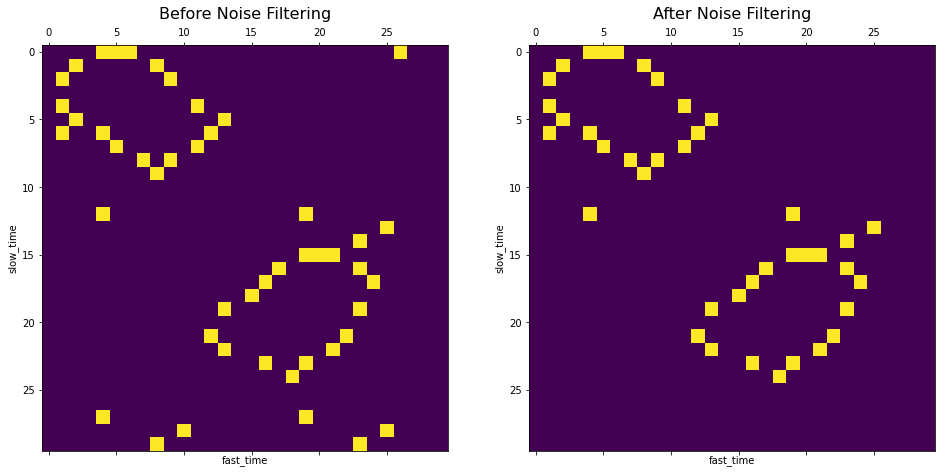

In [83]:
# find noise data points
def get_noise1(matrix, k_size, threshold):
    m_height, m_width = matrix.shape
    padded = np.pad(matrix, (k_size-1, k_size-1))

    output = []
    for i in range(m_height):
        for j in range(m_width):
            t_mat=padded[i:k_size+i, j:k_size+j]
            t=t_mat.sum()
            if (t>threshold):
              padded[i:k_size+i, j:k_size+j]=0
    return padded[k_size-1:m_height+k_size-1,k_size-1:m_width+k_size-1]

noise1 = get_noise1(filtered2,9,3)
filtered3 = filtered2 - noise1 # remove noise data


f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))

# f, ax = plt.subplots(2,figsize=(8,8))
ax1.set_title('Before Noise Filtering',fontsize = 16)
ax1.set(xlabel='fast_time', ylabel='slow_time')
ax1.matshow(filtered2)

# f, ax = plt.subplots(figsize=(8,8))
ax2.set_title('After Noise Filtering',fontsize = 16)
ax2.set(xlabel='fast_time', ylabel='slow_time')
ax2.matshow(filtered3)

plt.show()


## Remove noise: Stage 2

### `filter(matrix, k_size, threshold)` : returns noise removed matrix
Inputs
*   Data matrix
*   Kernal size
*   threshold

Output
*   Matrix of noise removed (same size as the input matrix)

Method
*   Run a square Kernal on the input matrix
* Adds up values under kernel
* If the sum is less than threshold `which means its random noise point or spike` erase (set to zero) only center of the kernel
* Return the resultant matrix



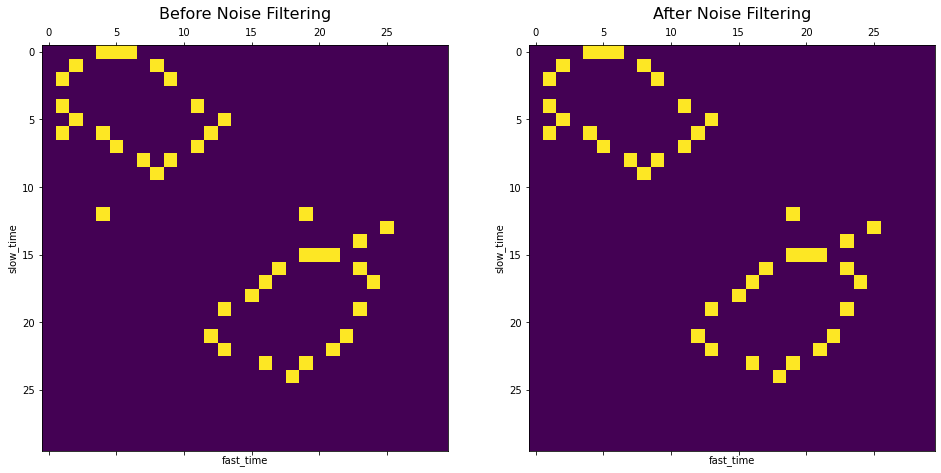

In [84]:
# find noise data points
def filter(matrix, k_size, threshold):
    m_height, m_width = matrix.shape
    padded = np.pad(matrix, (k_size-1, k_size-1))

    output = []
    for i in range(m_height):
        for j in range(m_width):
            t_mat=padded[i:k_size+i, j:k_size+j]
            t=t_mat.sum()
            if (t<threshold):
              padded[i,j]=0
    return padded[k_size-1:m_height+k_size-1,k_size-1:m_width+k_size-1]

filtered4 = filter(filtered3,9,2)

f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))

# f, ax = plt.subplots(2,figsize=(8,8))
ax1.set_title('Before Noise Filtering',fontsize = 16)
ax1.set(xlabel='fast_time', ylabel='slow_time')
ax1.matshow(filtered3)

# f, ax = plt.subplots(figsize=(8,8))
ax2.set_title('After Noise Filtering',fontsize = 16)
ax2.set(xlabel='fast_time', ylabel='slow_time')
ax2.matshow(filtered4)

plt.show()

## Connecting Gaps of cloud edges.
To run flood_fill algorithm cloud edges must not contain gaps.

### `connect_two_pixel_gaps(mat):` connect 2 slot gap in 4*4 matrix
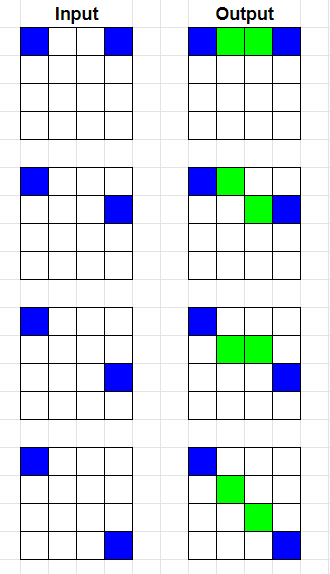

### `connect_one_pixel_gaps(mat)` : connect 1 slot gap in 3*3 matrix
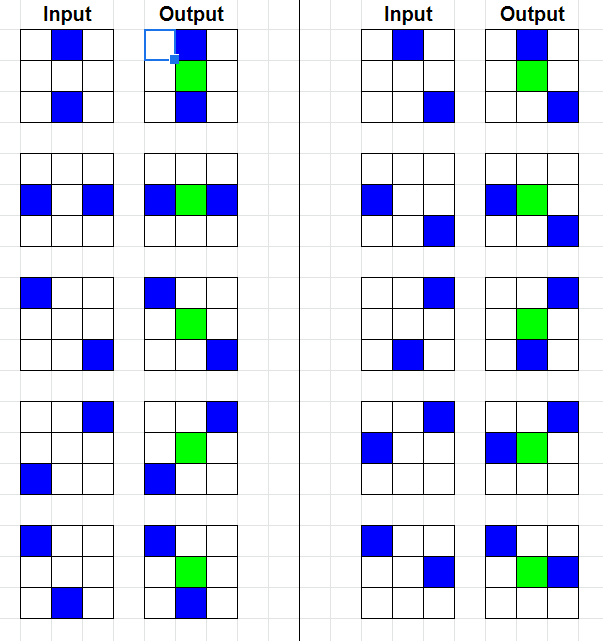

### `draw1(InputMat,k_size)` : Fill two slot gaps in given matrix
run kernal on `InputMat` and feed `connect_two_pixel_gaps` function.
this function apply `connect_two_pixel_gaps` function on,

* Input matrix
* Fliped input matrix 
* Transposed fliped matrix 

finally return the resulted matrix.

### `draw2(InputMat,k_size)` : Fill two slot gaps in given matrix
run kernal on `InputMat` and feed `connect_one_pixel_gaps` function.
this function apply `connect_one_pixel_gaps` function on,

* Input matrix
* Fliped input matrix 
* Transposed fliped matrix 

finally return the resulted matrix.





In [85]:
# connecting discontinous gaps of cloud contours

def connect_two_pixel_gaps(mat):
    for i in range (4):
        if  (mat[i,0] ==1 and mat[i,3]==1) : 
          mat[i,1:3] = 1
        elif (i<3) and (mat[i,0] ==1 and mat[i+1,3]==1) :
          mat[i,1] = 1
          mat[i+1,2]=1
        elif (i<2) and (mat[i,0] ==1 and mat[i+2,3]==1) :
          mat[i+1,1] = 1
          mat[i+2,2]=1
        elif (i<1) and (mat[i,0] ==1 and mat[i+3,3]==1) :
          mat[i+1,1] = 1
          mat[i+2,2]=1
    return mat 

def connect_one_pixel_gaps(mat):
    if((mat[0,0] == 1 and mat[2,2] == 1) 
    or (mat[0,2] == 1 and mat[2,0] == 1)  
    or (mat[1,0] == 1 and mat[1,2] == 1) 
    or (mat[0,1] == 1 and mat[2,1] == 1)
    or (mat[0,0] == 1 and (mat[2,1] == 1 or mat[1,2] == 1))
    or (mat[0,2] == 1 and (mat[1,0] == 1 or mat[2,1] == 1))
    or (mat[2,0] == 1 and (mat[0,1] == 1 or mat[1,2] == 1))
    or (mat[2,2] == 1 and (mat[1,0] == 1 or mat[0,1] == 1))): mat[1,1] = 1
    return mat

def draw1 (InputMat,k_size):
  h,w = InputMat.shape
  padded = np.pad(InputMat, (k_size-1, k_size-1))

  for i in range(h):
    for j in range(w):
        t_mat1 = padded[i:k_size+i, j:k_size+j]
        t_mat2 = np.flip(connect_two_pixel_gaps(t_mat1),axis=1)
        t_mat3 = np.flip(connect_two_pixel_gaps(t_mat2),axis=1)
        padded[i:k_size+i, j:k_size+j] = np.transpose(connect_two_pixel_gaps(np.transpose(t_mat3)))
  return padded[k_size-1:h+k_size-1,k_size-1:w+k_size-1]


def draw2 (InputMat,k_size):
  h,w = InputMat.shape
  padded = np.pad(InputMat, (k_size-1, k_size-1))
  for i in range(h):
    for j in range(w):
      t_mat1 = padded[i:k_size+i, j:k_size+j]
      t_mat2 = connect_one_pixel_gaps(t_mat1)
      padded[i:k_size+i, j:k_size+j] = t_mat2

  return padded[k_size-1:h+k_size-1,k_size-1:w+k_size-1]


## Apply above functions on filtered data matrix.

Apply noise after each gap filling process to reduce noises and spikes.

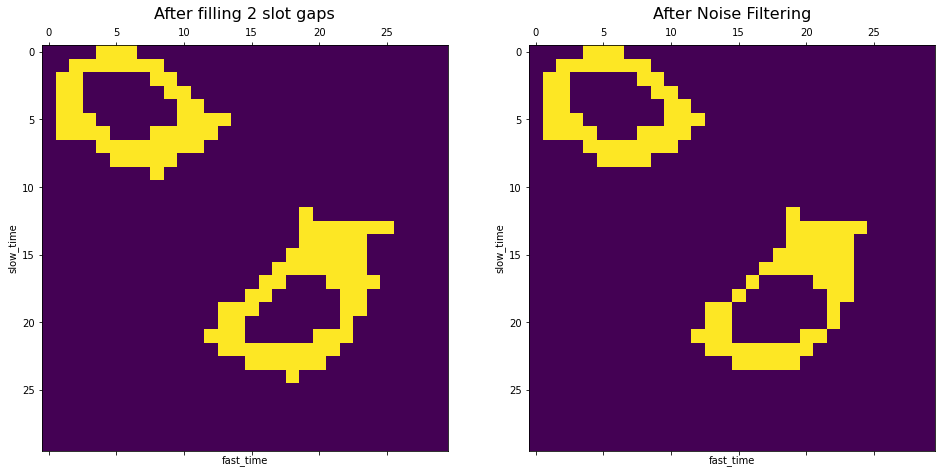

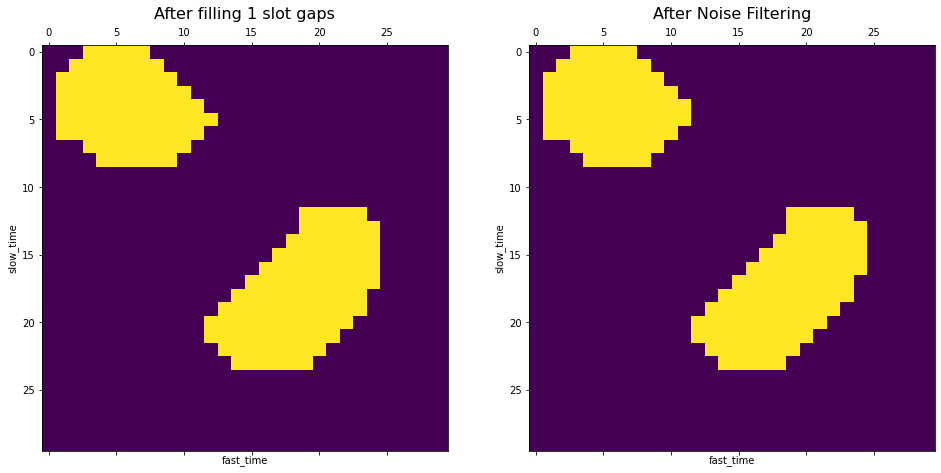

In [86]:
# connect two slot gaps
draw_2 = draw1(filtered4,4)

# filtering
filtered5 = filter(draw_2,3,2)

# connect single slot gaps
draw_1 =draw2(filtered5,3)

# filtering
filtered6 = filter(draw_1,3,2)

f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,16))

# f, ax = plt.subplots(2,figsize=(8,8))
ax1.set_title('After filling 2 slot gaps',fontsize = 16)
ax1.set(xlabel='fast_time', ylabel='slow_time')
ax1.matshow(draw_2)

# f, ax = plt.subplots(figsize=(8,8))
ax2.set_title('After Noise Filtering',fontsize = 16)
ax2.set(xlabel='fast_time', ylabel='slow_time')
ax2.matshow(filtered5)

plt.show()

f, (ax3, ax4) = plt.subplots(1,2,figsize=(16,16))
# f, ax = plt.subplots(2,figsize=(8,8))
ax3.set_title('After filling 1 slot gaps',fontsize = 16)
ax3.set(xlabel='fast_time', ylabel='slow_time')
ax3.matshow(draw_1)

# f, ax = plt.subplots(figsize=(8,8))
ax4.set_title('After Noise Filtering',fontsize = 16)
ax4.set(xlabel='fast_time', ylabel='slow_time')
ax4.matshow(filtered6)
plt.show()

## Filling cloud contours



*   Fill the whole area outside the cloud contours with `-1`s to mask out non-cloud area.
*   Then in the next stage all slots with `-1` are set to `0`s and other slots are filled with `1`s.



### `find_seed_point(inputMat)` : flood_fill algoritham requires a position to start with (seed). this function searches first non-cloud slot and return. 

`
 Note: After a single gap filling, clouds look like they are filled entirely (not only edges). But this is not guaranteed. So that's why flood filling is required.
`


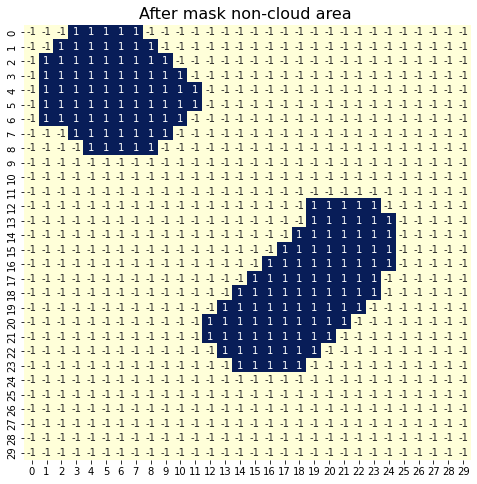

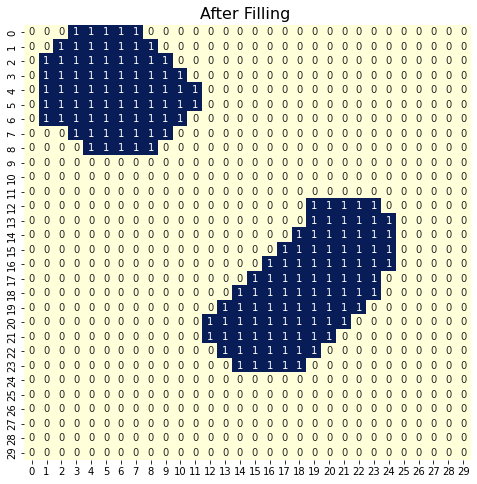

In [87]:
# Filling up any remaining contours 
from skimage.morphology import flood_fill

#find seed point for flooding


def find_seed_point(inputMat):
  h,w = inputMat.shape
  for i in range(h):
      for j in range(w):
        if(filtered6[i,j]== 0):
          return (i,j)
(s1,s2) = find_seed_point(filtered6)

masked = flood_fill(filtered6,(s1,s2),-1,connectivity=1) # fillout all outer non-cloud slots with -1 

f, ax = plt.subplots(figsize=(8,8))
plt.title('After mask non-cloud area ',fontsize = 16)
ax = sns.heatmap(masked, square=False,annot=True,cbar=False,cmap="YlGnBu")

filled = np.where(masked>=0,1,0)

f, ax = plt.subplots(figsize=(8,8))
plt.title('After Filling ',fontsize = 16)
ax = sns.heatmap(filled, square=False,annot=True,cbar=False,cmap="YlGnBu")


## Add objects to the final matrix

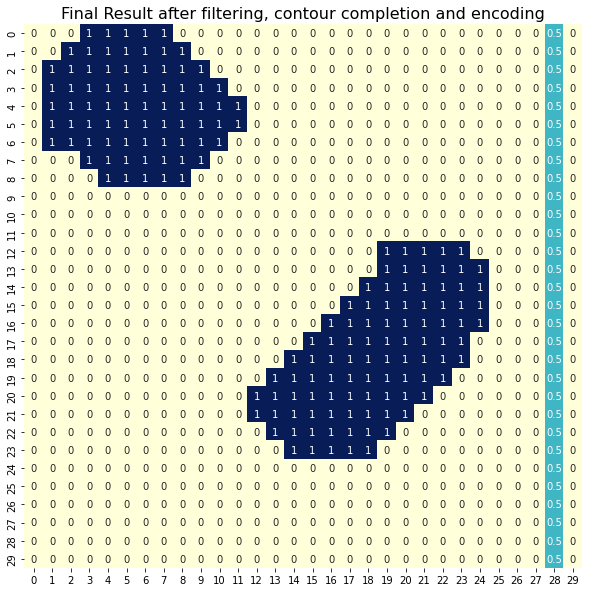

In [88]:
# adding detected objects

final = filled.astype(float)
final[:,possible_object_slots] = 0.5

f, ax = plt.subplots(figsize=(10,10))
plt.title('Final Result after filtering, contour completion and encoding',fontsize = 16)
plt.xlabel('fast_time')
plt.xlabel('slow_time')

ax = sns.heatmap(final, square=False,annot=True,cbar=False,cmap="YlGnBu")